In [ ]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
import glob
import math
from datetime import date
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': '16'})
import warnings; warnings.simplefilter('ignore')

# Introduction to parallel concepts



## Serial Execution
Typical programs operate lines sequentially:

In [3]:
# Define an array of numbers
foo = np.array([0, 1, 2, 3, 4, 5])

# Define a function that squares numbers
def bar(x):
    return x * x

# Loop over each element and perform an action on it
for element in foo:

        # Print the result of bar
        print(bar(element))

0
1
4
9
16
25


## The `map` function

A key tool that we will utilize later is called `map`. This lets us apply a function to each element in a list or array:

In [4]:
# (Very) inefficient way to define a map function
def my_map(function, array):
    # create a container for the results
    output = []

    # loop over each element
    for element in array:
        
        # add the intermediate result to the container
        output.append(function(element))
    
    # return the now-filled container
    return output


In [5]:
my_map(bar, foo)

[0, 1, 4, 9, 16, 25]


Python has a helpfully provided a `map` function in the standard library:

In [6]:
list(map(bar, foo))

# NB: in python3 `map` is a generator, so we need to cast it to a list for this comparison

[0, 1, 4, 9, 16, 25]

The built-in `map` function is much more flexible and featured than ours, so it's best to use that one instead. 

## Parallel Workers

In the example we showed before, no step of the `map` call depend on the other steps. 

Rather than waiting for the function to loop over each value, we could create multiple instances of the function `bar`  and apply it to each value simultaneously.

This is achieved with the `multiprocessing` module and a pool of workers.



## The `Mutiprocessing` module

The `multiprocessing` module has a number of functions to help simplify parallel processing.

One such tool is the `Pool` class. It allows us to set up a group of processes to excecute tasks in parallel. This is called a pool of worker processes. 

First we will create the pool with a specified number of workers. We will then use our `map` utility to apply a function to our array. 

In [7]:
import multiprocessing
multiprocessing.set_start_method("fork")

# Create a pool of processes
with multiprocessing.Pool(processes=6) as pool:
    # map the `np.square` function on our `foo` array
    result = pool.map(np.square, foo)

# output the results
print(result)


[0, 1, 4, 9, 16, 25]


The difference here is that each element of this list is being handled by a different process. 



To show how this is actually being handled, let's create a new function:

In [8]:
def parallel_test(x):
    # print the index of the job and it's process ID number
    s = f"x = {x}, PID = {os.getpid()}"
    print(s)
    return s

Now we can map this function on the `foo` array from before. First with the built-in `map` function:

In [9]:
list(map(parallel_test, foo));

x = 0, PID = 3864
x = 1, PID = 3864
x = 2, PID = 3864
x = 3, PID = 3864
x = 4, PID = 3864
x = 5, PID = 3864


We see that each step is being handled by the same process and are excecuted in order.

Now we try the same process using `multiprocessing`:

In [11]:
with multiprocessing.Pool(processes=6) as pool:
    result = pool.map(parallel_test, foo)

x = 3, PID = 3886x = 1, PID = 3884x = 2, PID = 3885x = 4, PID = 3887x = 5, PID = 3888x = 0, PID = 3883







Two things are worth noting:
1. Each element is processed by a different PID
2. The tasks are not executed in order!


## Key Take-aways

1. The `map` function is designed to apply the same function to each item in an iterator
2. In serial processing, this works like a for-loop
3. Parallel execution sets up multiple worker processes that act separately and simultaneously

## Example 1: Monte Carlo Pi Calculation

- Run multiple instances of the same simulation with different random number generator seeds
- Define a function to calculate `pi` that takes the random seed as input, then map it on an array of random seeds

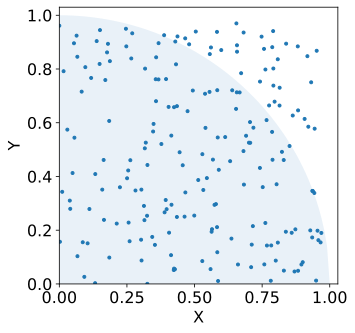

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
x = np.linspace(0,1,100)
plt.fill_between(x, np.sqrt(1-x**2),0,alpha=0.1)
plt.xlim(0,1.03);plt.ylim(0,1.03);plt.xlabel('X');plt.ylabel('Y');

x = np.random.random(size=200)
y = np.random.random(size=200)

plt.plot(x,y,marker='.',linestyle='None');


In [13]:
def pi_mc(seed):
    num_trials = 500000
    counter = 0
    np.random.seed(seed)
    
    for j in range(num_trials):
        x_val = np.random.random_sample()
        y_val = np.random.random_sample()

        radius = x_val**2 + y_val**2

        if radius < 1:
            counter += 1
            
    return 4*counter/num_trials

### Serial vs Parallel

In [14]:
%timeit pi_mc(1)

228 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
seed_array = list(range(4))
%timeit list(map(pi_mc, seed_array))

924 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

with multiprocessing.Pool(processes=4) as pool:
    result = pool.map(pi_mc, seed_array)

251 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While the serial execution scales up linearly (~4x longer than one loop), the parallel execution doesn't quite reach the single iteration performance. There is some overhead in setting up the threads that needs to be considered.

## `Joblib` parallel for-loops

The `joblib` module aims to simplify the creation of pipelines which can orchestrate multi-step analyses. 
It can also simply manage embarassingly parallel problems much like `multiprocessing`. 

In [18]:
import joblib

In [19]:
joblib.Parallel(n_jobs=4)(joblib.delayed(pi_mc)(i) for i in range(10))

[3.139272,
 3.1424,
 3.144096,
 3.141536,
 3.135888,
 3.137824,
 3.141552,
 3.141672,
 3.141992,
 3.142352]

## Example 2: Processing multiple input files

Say we have a number of input files, like `.jpg` images, that we want to perform the same actions on, like rotate by 180 degrees and convert to a different format. 

We can define a function that takes a file as input and performs these actions, then map it on a list of files.


In [20]:
# import python image library functions
from PIL import Image

from matplotlib.pyplot import imshow
%matplotlib inline

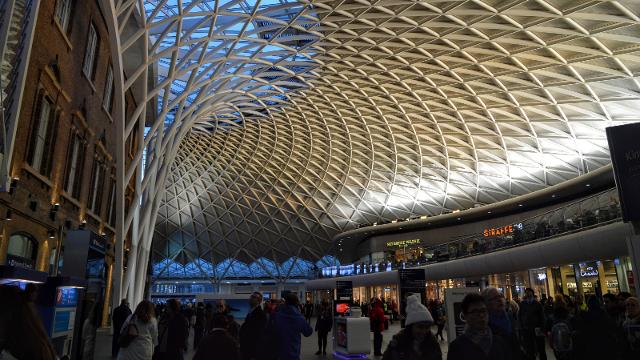

In [21]:
#Read image
im = Image.open( './data/kings_cross.jpg' )
#Display image
im

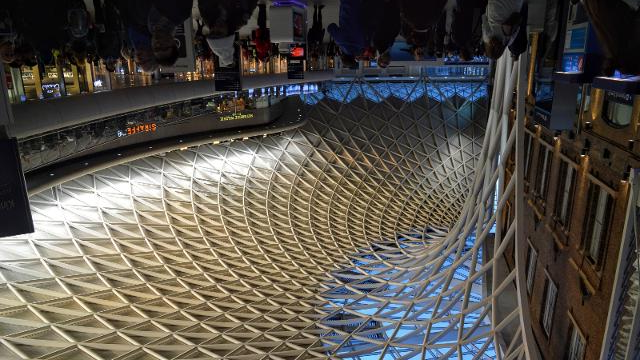

In [22]:
im.rotate(angle=180)

Let's define a function that takes a file name as input, opens the file, rotates it upside down, and then saves the output as a PDF:

In [23]:
def image_flipper(file_name):
    # extract the base file name
    base_name = file_name[0:-4]
    
    # opens the file
    im = Image.open( file_name )

    # rotates by 180deg
    im_flipped = im.rotate(angle=180)
    
    # Saves a PDF output with a new file name
    im_flipped.save(base_name + "_flipped.pdf", format='PDF')

    return base_name + "_flipped.pdf"

In [24]:
file_list = glob.glob('./data/*jpg')

for f in file_list:
    print(f)

./data/kings_cross.jpg
./data/charing_cross.jpg
./data/victoria.jpg
./data/waterloo.jpg
./data/euston.jpg
./data/fenchurch.jpg
./data/st_pancras.jpg
./data/london_bridge.jpg
./data/liverpool_street.jpg
./data/paddington.jpg


In [25]:
joblib.Parallel(n_jobs=4)(joblib.delayed(image_flipper)(f) for f in file_list)

['./data/kings_cross_flipped.pdf',
 './data/charing_cross_flipped.pdf',
 './data/victoria_flipped.pdf',
 './data/waterloo_flipped.pdf',
 './data/euston_flipped.pdf',
 './data/fenchurch_flipped.pdf',
 './data/st_pancras_flipped.pdf',
 './data/london_bridge_flipped.pdf',
 './data/liverpool_street_flipped.pdf',
 './data/paddington_flipped.pdf']

We have created a set of PDF files with new file names and inverted images. 

In [26]:
%ls ./data/*pdf

./data/charing_cross_flipped.pdf     ./data/london_bridge_flipped.pdf
./data/euston_flipped.pdf            ./data/paddington_flipped.pdf
./data/fenchurch_flipped.pdf         ./data/st_pancras_flipped.pdf
./data/kings_cross_flipped.pdf       ./data/victoria_flipped.pdf
./data/liverpool_street_flipped.pdf  ./data/waterloo_flipped.pdf


![](./data/euston_flipped.pdf)

## Key Take-aways
1. These problems are essentially independent and share no information between them.
2. The `multiprocessing` and `joblib` modules makes it simple to run these steps together with a single command
3. This workflow is limited to running on a single computer (or compute node) since there is no mechanism to communicate outside